In [36]:
# %matplotlib widget

import os
from copy import deepcopy as copy
import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from scipy import interpolate
from astropy.stats import biweight_location, biweight_midvariance
from sklearn.decomposition import NMF


from lvmdrp import path, log, __version__ as drpver
from lvmdrp.utils import metadata as md
from lvmdrp.core.constants import SPEC_CHANNELS
from lvmdrp.core.fiberrows import FiberRows
from lvmdrp.core.spectrum1d import Spectrum1D
from lvmdrp.core.rss import RSS
from lvmdrp.functions import run_drp as drp
from lvmdrp.functions import run_quickdrp as qdrp

from lvmdrp.functions import imageMethod, rssMethod


ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")
MASTER_CON_LAMPS = {"b": "ldls", "r": "ldls", "z": "quartz"}
# MASTER_ARC_LAMPS = {"b": "hgne", "r": "neon", "z": "neon"}
MASTER_ARC_LAMPS = {"b": "neon_hgne_argon_xenon", "r": "neon_hgne_argon_xenon", "z": "neon_hgne_argon_xenon"}
SLITMAP = Table(drp.fibermap.data)

mask_bands = {
    "b": [(3910, 4000), (4260, 4330)],
    "r": [(6260, 6300), (6530, 6600), (6670, 6750), (6800, 7060), (7090, 7450)],
    "z": [(7580, 7700), (8060, 8680), (8900, 9180), (9250, 9750)]
}
mask_bands = {
    "b": [(3910, 4000), (4260, 4330)],
    "r": [],
    "z": [(7570, 7700)]
}



def fit_continuum(spec, median_box=30, thresh=1.2, niter=5, poly_deg=10, wave_range=None, wave_masks=None, reset_mask=True):
    
    # mask bad pixels
    # spec._data[spec._mask] = np.nan
    spec._mask[:] = False

    # mask wavelength regions
    if wave_range is not None:
        iwave, fwave = wave_range
        spec._mask = ~((iwave <= spec._wave) & (spec._wave <= fwave))
        spec._data[spec._mask] = np.nan
    
    # mask wavelength regions
    if wave_masks is not None:
        for iwave, fwave in wave_masks:
            spec._mask |= (iwave <= spec._wave) & (spec._wave <= fwave)
            spec._data[spec._mask] = np.nan

    # copy original spectrum object
    spec_s = copy(spec)

    # replace bad pixels with NaNs
    spec_s._data[spec_s._mask] = np.nan
    spec_s._data = median_filter(spec_s._data, size=median_box)

    for i in range(niter):
        mask = np.divide(spec._data, spec_s._data, where=spec_s._data != 0, out=np.zeros_like(spec_s._data)) > thresh

        spec_s = Spectrum1D(data=np.interp(spec._pixels, spec._pixels[mask], spec._data[mask]))
        spec_s._data = median_filter(spec_s._data, median_box)


    # define continuum with last iteration's mask
    mask = np.divide(spec._data, spec_s._data, where=spec_s._data != 0, out=np.zeros_like(spec_s._data)) > thresh
    
    # create continuum spectrum and update mask
    out_con = copy(spec)
    out_con._mask |= ~mask

    # fit polynomial function
    coeffs = out_con.smoothSpec(size=poly_deg, method="BSpline")
    # coeffs = out_con.smoothPoly(deg=poly_deg)

    # reset mask
    if reset_mask:
        out_con._mask[:] = False
    
    return coeffs, out_con

def create_twilight_flat(in_rsss, out_rsss, in_waves=None, median_box=50, wave_range=None, wave_masks=None,
                         clip_sigma=None, thresh=1.0001, niter=1, poly_deg=10, display_plots=True):

    # stack twilight flats
    rss = RSS()
    rss.loadFitsData(in_rsss[0])
    rsss = [rssMethod.loadRSS(in_rss) for in_rss in in_rsss]
    flat = rss.stackRSS(rsss, axis=1)

    # copy original twilight flat
    orig_flat = copy(flat)

    # useful metadata
    camera = rss._header["CCD"]
    unit = rss._header["BUNIT"]

    # update mask for invalid values
    flat._mask |= np.isnan(flat._data) | np.isinf(flat._data)

    # interpolate bad pixels in each fiber
    flat.interpolate_data(axis="X", reset_mask=False)

    # remove high-frequency features and update mask
    if median_box is not None:
        flat._data = median_filter(flat._data, (1, median_box))
        flat._mask |= np.isnan(flat._data)

    # sigma clipping
    if clip_sigma is not None:
        if isinstance(clip_sigma, (int, float)):
            low, high = clip_sigma, clip_sigma
        elif isinstance(clip_sigma, (list, tuple)) and len(clip_sigma) == 2:
            low, high = clip_sigma
        else:
            raise ValueError("clip_sigma must be a number or a list/tuple of two numbers")
        
        ave = biweight_location(flat._data, axis=1, ignore_nan=True)
        std = biweight_midvariance(flat._data, axis=1, ignore_nan=True)
        mask = ~flat._mask | (np.abs(flat._data - ave[:, None]) < low * std[:, None]) | (np.abs(flat._data - ave[:, None]) > high * std[:, None])
        flat._data[~mask] = np.nan
        flat._mask[~mask] = True
        flat.interpolate_data(axis="X", reset_mask=False)

    # mask bad fibers
    fibermap = flat._slitmap
    select_bad = fibermap["fibstatus"] == 1
    flat._mask[select_bad] = True
    flat._data[select_bad] = np.nan

    # fit continuum above absorption features
    flat._coeffs = np.zeros((flat._fibers, poly_deg+1))
    for ifiber in range(flat._fibers):
        flat_spec = flat[ifiber]
        # skip if all pixels are masked
        if flat_spec._mask.all():
            continue
        # fit continuum
        coeffs, cont_spec = fit_continuum(flat_spec, thresh=thresh, niter=niter, median_box=median_box, poly_deg=poly_deg, wave_range=wave_range, wave_masks=wave_masks)
        cont_spec._mask[:] = False
        # update flatfielded spectrum
        flat[ifiber] = cont_spec
        # update coefficients
        flat._coeffs[ifiber] = coeffs
    
    # interpolate bad fibers
    flat.interpolate_coeffs()

    # plot flatfielded twilight flat
    if display_plots:
        fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True, sharey=True)
        plt.ylim(0, 1.5)
        axes[0].set_title(f"Twilight flat for channel = {camera[0]}", loc="left")
        for window in wave_masks:
            axes[0].axvspan(*window, color="k", alpha=0.5)
            axes[1].axvspan(*window, color="k", alpha=0.5)
            axes[2].axvspan(*window, color="k", alpha=0.5)
        if wave_range is not None:
            axes[0].axvline(wave_range[0], color="k", ls="--", lw=1)
            axes[0].axvline(wave_range[1], color="k", ls="--", lw=1)
            axes[1].axvline(wave_range[0], color="k", ls="--", lw=1)
            axes[1].axvline(wave_range[1], color="k", ls="--", lw=1)
            axes[2].axvline(wave_range[0], color="k", ls="--", lw=1)
            axes[2].axvline(wave_range[1], color="k", ls="--", lw=1)

        # color by fiber status
        # dead_fibers = fibermap["fibstatus"] == 1
        # weak_fibers = fibermap["fibstatus"] == 2
        # good_fibers = fibermap["fibstatus"] == 0
        dead_fibers = fibermap["spectrographid"] == 1
        weak_fibers = fibermap["spectrographid"] == 2
        good_fibers = fibermap["spectrographid"] == 3
        axes[0].step(orig_flat._wave[dead_fibers].T, orig_flat._data[dead_fibers].T, lw=1, color="0.2", alpha=0.1)
        axes[0].step(orig_flat._wave[weak_fibers].T, orig_flat._data[weak_fibers].T, lw=1, color="tab:orange", alpha=0.1)
        axes[0].step(orig_flat._wave[good_fibers].T, orig_flat._data[good_fibers].T, lw=1, color="tab:blue", alpha=0.1)
        axes[1].plot(flat._wave[dead_fibers].T, flat._data[dead_fibers].T, lw=1, color="0.2", alpha=0.1)
        axes[1].plot(flat._wave[weak_fibers].T, flat._data[weak_fibers].T, lw=1, color="tab:orange", alpha=0.1)
        axes[1].plot(flat._wave[good_fibers].T, flat._data[good_fibers].T, lw=1, color="tab:blue", alpha=0.1)
        axes[2].step(orig_flat._wave[dead_fibers].T, (orig_flat._data / flat._data)[dead_fibers].T, lw=1, color="0.2", alpha=0.1)
        axes[2].step(orig_flat._wave[weak_fibers].T, (orig_flat._data / flat._data)[weak_fibers].T, lw=1, color="tab:orange", alpha=0.1)
        axes[2].step(orig_flat._wave[good_fibers].T, (orig_flat._data / flat._data)[good_fibers].T, lw=1, color="tab:blue", alpha=0.1)
        axes[2].set_xlabel("Wavelength (Angstrom)")
        axes[0].set_ylabel(f"Counts ({unit})")
        axes[1].set_ylabel("Relative counts")
        axes[2].set_ylabel(f"Counts ({unit})")
        plt.show()

    # split RSS into individual spectrographs
    for i, new_flat in enumerate(flat.splitRSS(axis=1, parts=len(in_rsss))):
        # resample back to the native wavelength grid
        if in_waves is not None:
            waves = FiberRows()
            waves.loadFitsData(in_waves[i])

            new_flats = []
            for ifiber in range(new_flat._fibers):
                new_flats.append(new_flat[ifiber].resampleSpec(waves[ifiber]._data[:-1], method="linear", err_sim=5))
            new_flat = RSS.from_spectra1d(new_flats)

        # update header and slitmap
        new_flat._header = rsss[i]._header
        new_flat._slitmap = rsss[i]._slitmap
        new_flat._good_fibers = rsss[i]._good_fibers
        # write output to disk
        new_flat.writeFitsData(out_rsss[i])

    return new_flat, new_flats

def decompose_twilight(rsss, interpolate_bad=True, median_box=20, n_components=3, niter=5000, tol=1e-4, random_state=0, display_plots=True):
    # stack data
    data, error, mask = [], [], []
    for rss in rsss:
        data.append(rss._data)
        error.append(rss._error)
        mask.append(rss._mask)

    wave = rsss[0]._wave
    data = np.row_stack(data)
    error = np.row_stack(error)
    mask = np.row_stack(mask)

    # handle bad pixels
    mask = np.isnan(data) | (data <= 0)
    data[mask] = np.nan
    error[mask] = np.nan

    # interpolate NaNs
    if interpolate_bad:
        for i in range(data.shape[0]):
            if np.all(~mask[i]):
                continue
            data[i] = np.interp(wave, wave[~mask[i]], data[i, ~mask[i]])
            error[i] = np.interp(wave, wave[~mask[i]], error[i, ~mask[i]])

    # median filter if needed
    if median_box:
        data = median_filter(data, size=(1,median_box))
        error = median_filter(error, size=(1,median_box))

    dec = NMF(n_components=n_components, random_state=random_state, max_iter=niter, tol=tol)
    dec.fit(data)
    weights = dec.transform(data)

    # plot components
    if display_plots:
        plt.figure(figsize=(15,10))
        plt.title("Twilight decomposition", loc="left")
        plt.step(wave, dec.components_.T / np.median(dec.components_, axis=1), label=[f"comp {i+1}" for i in range(N)])
        plt.legend(loc=1)
        plt.xlabel("Wavelength (Angstrom)")
        plt.ylabel("Normalized counts")

    # calculate sun continuum
    sun_continuum = (weights[:, 1:, None] * dec.components_[1:]).sum(axis=1)
    sun_continuum = np.split(sun_continuum, 3, axis=0)

    # normalize by solar continuum
    for rss, sun in zip(rsss, sun_continuum):
        rss._data = rss._data / sun
        rss._error = rss._error / sun
        rss._mask |= np.isnan(rss._data) | (rss._data <= 0)

    return rsss, sun_continuum

def get_sequence_metadata(expnums):
    """Returns metadata for a sequence of exposures"""
    paths = []
    for expnum in expnums:
        paths.extend(path.expand("lvm_raw", mjd="*", hemi="s", camspec="*", expnum=expnum))
    paths = sorted(paths)

    mjds = []
    for p in paths:
        mjds.append(int(path.extract("lvm_raw", p)["mjd"]))
    mjds = np.unique(mjds)

    metadata = []
    for mjd in mjds:
        metadata.append(md.get_frames_metadata(mjd=mjd))

    metadata = pd.concat(metadata, ignore_index=True)
    metadata.query("expnum in @expnums", inplace=True)
    metadata.sort_values(["camera", "expnum"], inplace=True)
    return metadata

def continuum_twilight(rsss, interpolate_bad=True, mask_bands=None,
                       median_box=5, niter=100, threshold=1,
                       plot_fibers=[0, 600, 1200, 1900], display_plots=False, **kwargs):

    camera = rsss[0]._header["CCD"]

    # stack rsss
    data, error, mask = [], [], []
    for rss in rsss:
        data.append(rss._data)
        error.append(rss._error)
        mask.append(rss._mask)

    flat = RSS(
        wave=rsss[0]._wave,
        data=np.row_stack(data),
        error=np.row_stack(error),
        mask=np.row_stack(mask),
        slitmap=rsss[0]._slitmap
    )

    ori_flat = copy(flat)
    new_flat = copy(flat)

    # mask bad pixels
    flat._mask |= np.isnan(flat._data) | (flat._data < 0) | np.isinf(flat._data)
    flat._data[flat._mask] = np.nan

    # interpolate bad pixels
    if interpolate_bad:
        flat.interpolate_data(axis="X", reset_mask=False)

    # mask wavelength bands
    if mask_bands is not None:
        for iwave, fwave in mask_bands:
            flat._mask |= (iwave <= flat._wave) & (flat._wave <= fwave)
            flat._data[flat._mask] = np.nan

    # remove high-frequency features and update mask
    flat._data = median_filter(flat._data, (1,median_box))
    flat._mask |= np.isnan(flat._data)

    # diplay plots
    if display_plots:
        fig, axs = plt.subplots(len(plot_fibers), figsize=(20,5*len(plot_fibers)), sharex=True)
        axs[0].set_title(f"Twilight flat for camera = {camera}", loc="left")
        fig.supxlabel("Wavelength (Angstrom)")
        fig.supylabel("Normalized counts")
        plt.subplots_adjust(hspace=0.05)

        if mask_bands is not None:
            for mask in mask_bands:
                for ax in axs:
                    ax.axvspan(*mask, color="0.9")
    
    for ifiber in range(flat._fibers):
        if display_plots and ifiber in plot_fibers:
            axs[plot_fibers.index(ifiber)].step(flat._wave, ori_flat._data[ifiber], color="0.7", lw=1)
            axs[plot_fibers.index(ifiber)].step(flat._wave, flat._data[ifiber], color="0.2", lw=1)

        good_pix = ~flat._mask[ifiber]
        nknots = kwargs.pop("nknots", 100)
        knots = np.linspace(
                    flat._wave[flat._wave.size // nknots],
                    flat._wave[-1 * flat._wave.size // nknots],
                    nknots,
                )
        if mask_bands:
            mask = np.ones_like(knots, dtype="bool")
            for iwave, fwave in mask_bands:
                mask[(iwave<=knots)&(knots<=fwave)] = False
            knots = knots[mask]
        kwargs.setdefault("t", knots)
        kwargs.setdefault("task", -1)
        f = interpolate.splrep(flat._wave[good_pix], flat._data[ifiber][good_pix], **kwargs)
        spline = interpolate.splev(flat._wave, f)
        for i in range(niter):

            residuals = spline - flat._data[ifiber]
            mask = spline - threshold*np.nanstd(residuals) > flat._data[ifiber]

            if display_plots and ifiber in plot_fibers:
                axs[plot_fibers.index(ifiber)].plot(flat._wave[mask], flat._data[ifiber][mask], ".", color="tab:blue", ms=5, mew=0)
                axs[plot_fibers.index(ifiber)].step(flat._wave, spline, color="tab:red", lw=1, alpha=0.5, zorder=niter+1)

            # add new outliers to mask
            flat._mask[ifiber] |= mask

            # update spline
            good_pix = ~flat._mask[ifiber]
            f = interpolate.splrep(flat._wave[good_pix], flat._data[ifiber][good_pix], **kwargs)
            new_spline = interpolate.splev(flat._wave, f)
            if np.mean(np.abs(new_spline - spline) / spline) <= 0.01:
                break
            else:
                spline = new_spline
    
        if display_plots and ifiber in plot_fibers:
            axs[plot_fibers.index(ifiber)].step(kwargs["t"], np.zeros_like(kwargs["t"]), ".k")
            axs[plot_fibers.index(ifiber)].step(flat._wave, spline, color="tab:red", lw=2)

        new_flat._data[ifiber] = spline

    # normalize by median fiber
    median_fiber = np.median(new_flat._data, axis=0)
    new_flat._data = new_flat._data / median_fiber
    new_flat._error = new_flat._error / median_fiber
    new_flat._mask[...] = False

    # flattield original twilight
    ori_flat._data = ori_flat._data / new_flat._data

    # plot flatfielded twilight flat
    if display_plots:
        fig, axs = plt.subplots(figsize=(20,7), sharex=True)
        axs.set_title(f"Flatfielded twilight for camera = {camera}", loc="left")
        fig.supxlabel("Wavelength (Angstrom)")
        fig.supylabel("Normalized counts")
        plt.subplots_adjust(hspace=0.05)

        for ifiber in range(flat._fibers):
            if ifiber in plot_fibers:
                axs.step(ori_flat._wave, ori_flat._data[ifiber], lw=1)                
    
    new_flats = new_flat.splitRSS(parts=len(rsss), axis=1)
    [new_flat.setSlitmap(rsss[0]._slitmap) for new_flat in new_flats]

    return new_flats

def combine_twilight_sequence(expnums, camera, output_dir):
    hflats = [rssMethod.loadRSS(path.expand("lvm_anc", drpver=drpver, tileid="*", mjd="*", kind="s", imagetype="flat", camera=camera, expnum=expnum)[0]) for expnum in expnums]

    # define output paths
    mflat_path = os.path.join(output_dir, f"lvm-mfiberflat_twilight-{camera}.fits")
    os.makedirs(os.path.dirname(mflat_path), exist_ok=True)

    # combine RSS exposures using an average
    mflat = RSS(data=np.zeros_like(hflats[0]._data), error=np.zeros_like(hflats[0]._error), mask=np.ones_like(hflats[0]._mask, dtype=bool),
                header=copy(hflats[0]._header), slitmap=copy(hflats[0]._slitmap))
    # select non-std fibers
    fibermap =  mflat._slitmap[mflat._slitmap["spectrographid"] == int(camera[1])]
    select_allstd = fibermap["telescope"] == "Spec"
    select_nonstd = ~select_allstd
    for i, hflat in enumerate(hflats):
        # coadding all non-std fibers
        mflat._data[select_nonstd] = mflat._data[select_nonstd] + hflat._data[select_nonstd]
        mflat._error[select_nonstd] = np.sqrt(mflat._error[select_nonstd]**2 + hflat._error[select_nonstd]**2)
        mflat._mask[select_nonstd] = mflat._mask[select_nonstd] & hflat._mask[select_nonstd]
        
        # put std fibers in the right position
        fiber_id = f"P1-{i+1}"
        idx = np.where(fibermap["orig_ifulabel"].value == fiber_id)
        mflat._data[idx] = hflat._data[idx]
        mflat._error[idx] = hflat._error[idx]
        mflat._mask[idx] = mflat._mask[idx] & hflat._mask[idx]
        mflat._header.update(hflat._header["STD*"])
    
    # compute average of non-std fibers
    mflat._data[select_nonstd] = mflat._data[select_nonstd] / len(hflats)
    mflat._error[select_nonstd] = mflat._error[select_nonstd] / np.sqrt(len(hflats))

    # mask invalid pixels
    mflat._mask |= np.isnan(mflat._data) | (mflat._data <= 0) | np.isinf(mflat._data)

    return mflat

def fit_flat(mflat, camera, mwave_path=None, smoothing=0.01, display_plots=True):
    # load master wavelength
    if mwave_path is not None:
        mwave = FiberRows()
        mwave.loadFitsData(mwave_path)
        mwave = mwave._data[:, :-1]
    else:
        mwave = np.repeat([mflat._wave], mflat._fibers, axis=0)

    # fit fiberflat
    new_flat = RSS(data=np.zeros_like(mwave),
                wave=mwave,
                mask=np.zeros_like(mwave, dtype="bool"),
                inst_fwhm=mflat._inst_fwhm)
    new_flat._header = mflat._header
    new_flat._slitmap = mflat._slitmap
    new_flat._good_fibers = mflat._good_fibers
    for ifiber in range(mflat._fibers):
        if mflat._mask[ifiber].all():
            continue

        f = interpolate.interp1d(mflat._wave, mflat._data[ifiber], bounds_error=False)
        new_flat._data[ifiber] = f(mwave[ifiber])
    
    return new_flat

def reduce_twilight_sequence(expnums, mask_bands=None):
    """Reduce the twilight sequence and produces master twilight flats"""
    # get parameters of first exposure
    flat_path = path.expand("lvm_raw", hemi="s", mjd="*", camspec="b1", expnum=expnums[0])[0]
    params = path.extract("lvm_raw", flat_path)
    params.pop("hemi")

    # get metadata
    flats = get_sequence_metadata(expnums)
    for flat in flats.to_dict("records"):

        # master calibration paths
        camera = flat["camera"]
        mjd = flat["mjd"]
        arc_lamp = MASTER_ARC_LAMPS[camera[0]]
        masters_mjd = qdrp.get_master_mjd(mjd)
        masters_path = os.path.join(ORIG_MASTER_DIR, f"{masters_mjd}")
        master_cals = {
            "pixelmask" : os.path.join(masters_path, f"lvm-mpixmask-{camera}.fits"),
            "bias" : os.path.join(masters_path, f"lvm-mbias-{camera}.fits"),
            "dark" : os.path.join(masters_path, f"lvm-mdark-{camera}.fits"),
            "pixelflat" : os.path.join(masters_path, f"lvm-mpixflat-{camera}.fits"),
            "cent" : os.path.join(masters_path, f"lvm-mtrace-{camera}.fits"),
            "width" : os.path.join(masters_path, f"lvm-mwidth-{camera}.fits"),
            "wave" : os.path.join(masters_path, f"lvm-mwave_{arc_lamp}-{camera}.fits"),
            "lsf" : os.path.join(masters_path, f"lvm-mlsf_{arc_lamp}-{camera}.fits")
        }

        # preprocess and detrend each frame
        flat_path = path.full("lvm_raw", camspec=flat["camera"], **flat)
        pflat_path = path.full("lvm_anc", drpver=drpver, kind="p", imagetype=flat["imagetyp"], **flat)
        dflat_path = path.full("lvm_anc", drpver=drpver, kind="d", imagetype=flat["imagetyp"], **flat)
        if os.path.isfile(dflat_path):
            log.info(f"skipping {dflat_path}, file already exist")
        else:
            imageMethod.preproc_raw_frame(in_image=flat_path, out_image=pflat_path, in_mask=master_cals.get("pixelmask"))
            imageMethod.detrend_frame(in_image=pflat_path, out_image=dflat_path,
                                      in_bias=master_cals.get("bias"), in_dark=master_cals.get("dark"),
                                      in_pixelflat=master_cals.get("pixelflat"), in_slitmap=SLITMAP)

        # extract 1D spectra for each frame
        xflat_path = path.full("lvm_anc", drpver=drpver, kind="x", imagetype=flat["imagetyp"], **flat)
        if os.path.isfile(xflat_path):
            log.info(f"skipping {xflat_path}, file already exist")
        else:
            imageMethod.extract_spectra(in_image=dflat_path, out_rss=xflat_path,
                                        in_trace=master_cals.get("cent"), in_fwhm=master_cals.get("width"),
                                        method="optimal", parallel=10)
        
        wflat_path = path.full("lvm_anc", drpver=drpver, kind="w", imagetype=flat["imagetyp"], **flat)
        if os.path.isfile(wflat_path):
            log.info(f"skipping {wflat_path}, file already exist")
        else:
            rssMethod.create_pixel_table(in_rss=xflat_path, out_rss=wflat_path,
                                         arc_wave=master_cals.get("wave"), arc_fwhm=master_cals.get("lsf"))
        
        hflat_path = path.full("lvm_anc", drpver=drpver, kind="h", imagetype=flat["imagetyp"], **flat)
        if os.path.isfile(hflat_path):
            log.info(f"skipping {hflat_path}, file already exist")
        else:
            iwave, fwave = SPEC_CHANNELS[flat["camera"][0]]
            rssMethod.resample_wavelength(in_rss=wflat_path, out_rss=hflat_path,
                                            disp_pix=0.5, start_wave=iwave, end_wave=fwave,
                                            err_sim=5, parallel=0, extrapolate=False)

    # decompose twilight spectra into sun continuum and twilight components
    for expnum in expnums:
        for channel in "brz":
            hflat_paths = sorted(path.expand("lvm_anc", drpver=drpver, tileid="*", mjd=mjd, kind="h", imagetype="flat", camera=f"{channel}?", expnum=expnum))
            sflat_paths = [path.full("lvm_anc", drpver=drpver, tileid=11111, mjd=mjd, kind="s", imagetype="flat", camera=f"{channel}{i+1}", expnum=expnum) for i in range(3)]

            if all([os.path.isfile(sflat_path) for sflat_path in sflat_paths]):
                log.info(f"skipping {','.join(sflat_paths)}, file already exist")
                continue
            else:
                hflats = [rssMethod.loadRSS(hflat_path) for hflat_path in hflat_paths]

                # fit fiber throughput
                sflats = continuum_twilight(rsss=hflats, median_box=5, niter=1000, threshold=0.5, mask_bands=mask_bands[channel], display_plots=False, nknots=50)

                # write output to disk
                for sflat, sflat_path in zip(sflats, sflat_paths):
                    sflat.writeFitsData(sflat_path)

    cameras = ["b1", "b2", "b3", "r1", "r2", "r3", "z1", "z2", "z3"]
    # combine twilights and fit master fiberflat
    new_flats = dict.fromkeys(cameras)
    for camera in cameras:

        mrss = combine_twilight_sequence(expnums=expnums, camera=camera, output_dir=masters_path)
        mrss.writeFitsData(path.full("lvm_master", drpver=drpver, tileid=11111, mjd=mjd, kind="mfiberflat", camera=camera))

        mwave_path = os.path.join(masters_path, f"lvm-mwave_{MASTER_ARC_LAMPS[camera[0]]}-{camera}.fits")
        new_flat = fit_flat(mrss, camera=camera, mwave_path=mwave_path, smoothing=0.01, display_plots=True)
        mflat_path = os.path.join(masters_path, f"lvm-mfiberflat_twilight-{camera}.fits")
        new_flat.writeFitsData(mflat_path)
        new_flats[camera] = new_flat
    
    return new_flats

In [37]:
reduce_twilight_sequence(expnums=list(range(7832, 7832+12)), mask_bands=mask_bands)

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0011XX/11111/60264/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028055/60264/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028007/60264/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1027XX/1027986/60264/raw_metadata.hdf5
[INFO]: Loading existing metadata store.
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0011XX/11111/60264/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028055/60264/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spe

[[3533.7112 3534.3381 3534.965  ... 5942.743  5943.29   5943.837 ]
 [3533.902  3534.529  3535.156  ... 5943.007  5943.5537 5944.1006]
 [3534.093  3534.7202 3535.3472 ... 5943.27   5943.817  5944.364 ]
 ...
 [3533.529  3534.156  3534.783  ... 5944.4233 5944.97   5945.5176]
 [3533.297  3533.9243 3534.5513 ... 5944.1284 5944.6753 5945.222 ]
 [3533.1243 3533.7512 3534.3784 ... 5943.896  5944.4434 5944.99  ]]
[[3513.4336 3514.0588 3514.6843 ... 5922.8984 5923.4434 5923.9883]
 [3513.6633 3514.2888 3514.914  ... 5923.1836 5923.7285 5924.2734]
 [3513.8936 3514.519  3515.1445 ... 5923.4688 5924.0137 5924.5586]
 ...
 [3512.1416 3512.7676 3513.3936 ... 5922.113  5922.6587 5923.204 ]
 [3511.9734 3512.599  3513.2249 ... 5921.861  5922.4062 5922.952 ]
 [3511.7827 3512.4082 3513.0337 ... 5921.526  5922.0713 5922.616 ]]
[[3522.5967 3523.2236 3523.8506 ... 5933.5425 5934.089  5934.6357]
 [3522.7954 3523.422  3524.0488 ... 5933.7197 5934.2656 5934.812 ]
 [3522.9941 3523.6204 3524.2468 ... 5933.896  5934

{'b1': <lvmdrp.core.rss.RSS at 0x7f240c01ac20>,
 'b2': <lvmdrp.core.rss.RSS at 0x7f241335b1f0>,
 'b3': <lvmdrp.core.rss.RSS at 0x7f2413358220>,
 'r1': <lvmdrp.core.rss.RSS at 0x7f241335a470>,
 'r2': <lvmdrp.core.rss.RSS at 0x7f240c01a710>,
 'r3': <lvmdrp.core.rss.RSS at 0x7f240c14c6d0>,
 'z1': <lvmdrp.core.rss.RSS at 0x7f240c0fac80>,
 'z2': <lvmdrp.core.rss.RSS at 0x7f24102a7c10>,
 'z3': <lvmdrp.core.rss.RSS at 0x7f2415b17190>}

In [27]:
camera = "z3"

arc_lamp = MASTER_ARC_LAMPS[camera[0]]
masters_mjd = qdrp.get_master_mjd(60264)
masters_path = os.path.join(ORIG_MASTER_DIR, f"{masters_mjd}")
master_cals = {
    "pixelmask" : os.path.join(masters_path, f"lvm-mpixmask-{camera}.fits"),
    "bias" : os.path.join(masters_path, f"lvm-mbias-{camera}.fits"),
    "dark" : os.path.join(masters_path, f"lvm-mdark-{camera}.fits"),
    "pixelflat" : os.path.join(masters_path, f"lvm-mpixflat-{camera}.fits"),
    "cent" : os.path.join(masters_path, f"lvm-mtrace-{camera}.fits"),
    "width" : os.path.join(masters_path, f"lvm-mwidth-{camera}.fits"),
    "wave" : os.path.join(masters_path, f"lvm-mwave_{arc_lamp}-{camera}.fits"),
    "lsf" : os.path.join(masters_path, f"lvm-mlsf_{arc_lamp}-{camera}.fits")
}

xflat_path = path.expand("lvm_anc", drpver=drpver, tileid="*", mjd="*", kind="x", imagetype="flat", expnum=7832, camera=camera)[0]
wflat_path = path.expand("lvm_anc", drpver=drpver, tileid="*", mjd="*", kind="w", imagetype="flat", expnum=7832, camera=camera)[0]
hflat_path = path.expand("lvm_anc", drpver=drpver, tileid="*", mjd="*", kind="h", imagetype="flat", expnum=7832, camera=camera)[0]

rssMethod.create_pixel_table(in_rss=xflat_path, out_rss=wflat_path,
                                         arc_wave=master_cals.get("wave"), arc_fwhm=master_cals.get("lsf"))

iwave, fwave = SPEC_CHANNELS[camera[0]]
rssMethod.resample_wavelength(in_rss=wflat_path, out_rss=hflat_path,
                              disp_pix=0.5, start_wave=iwave, end_wave=fwave,
                              err_sim=5, parallel=0, extrapolate=False)

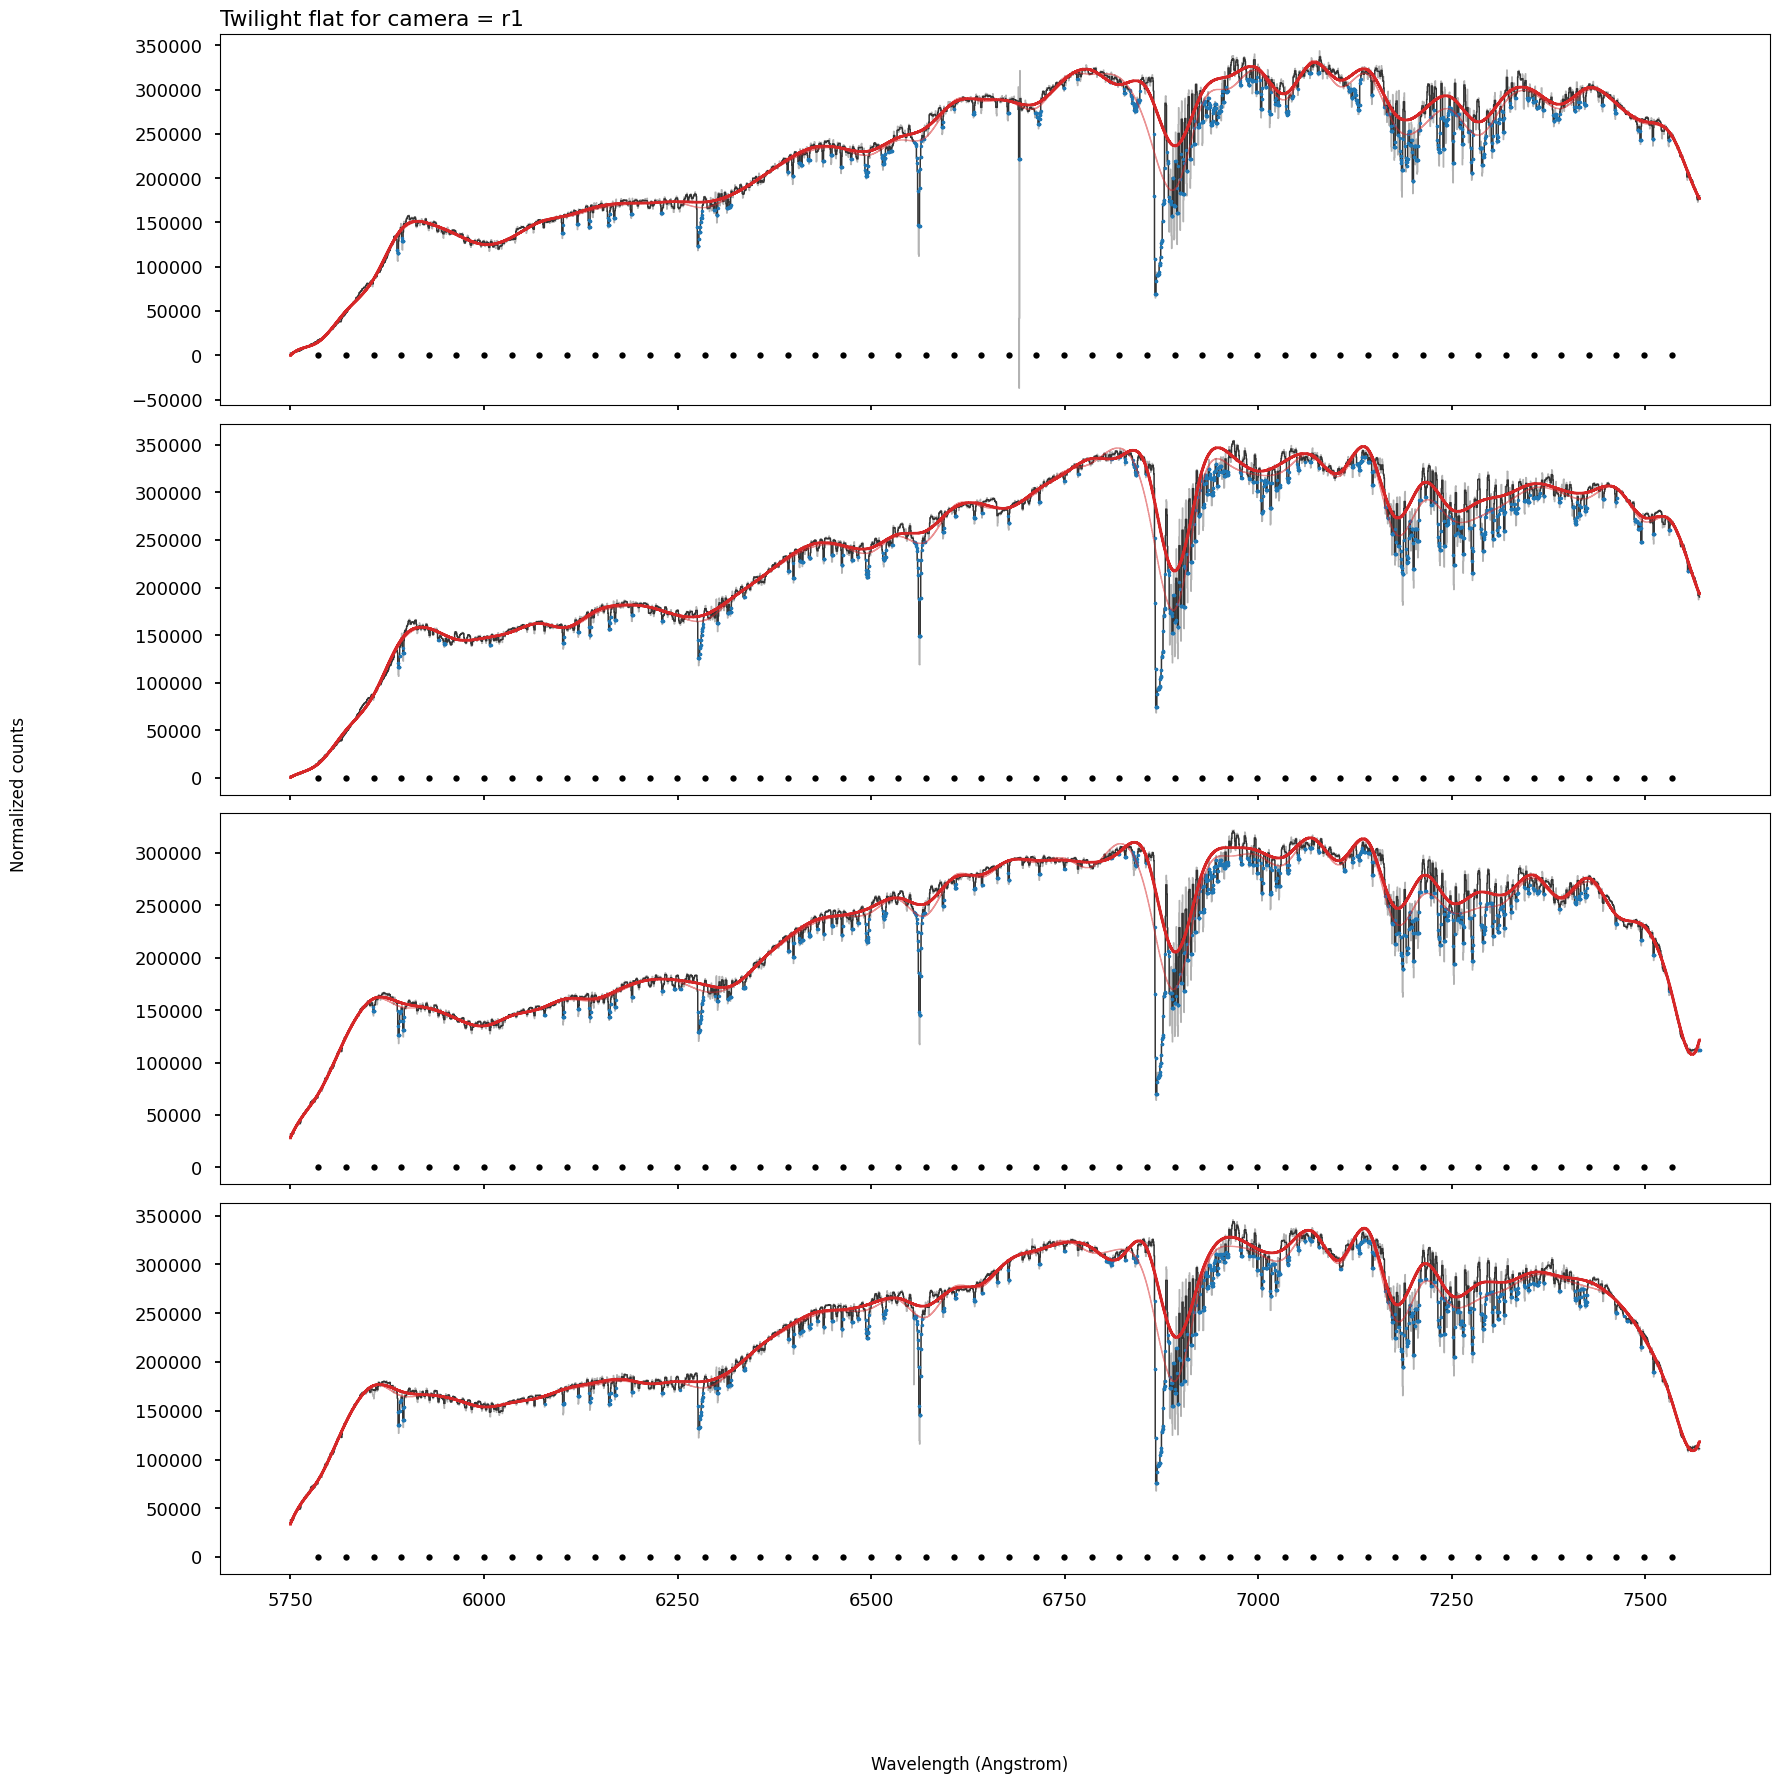

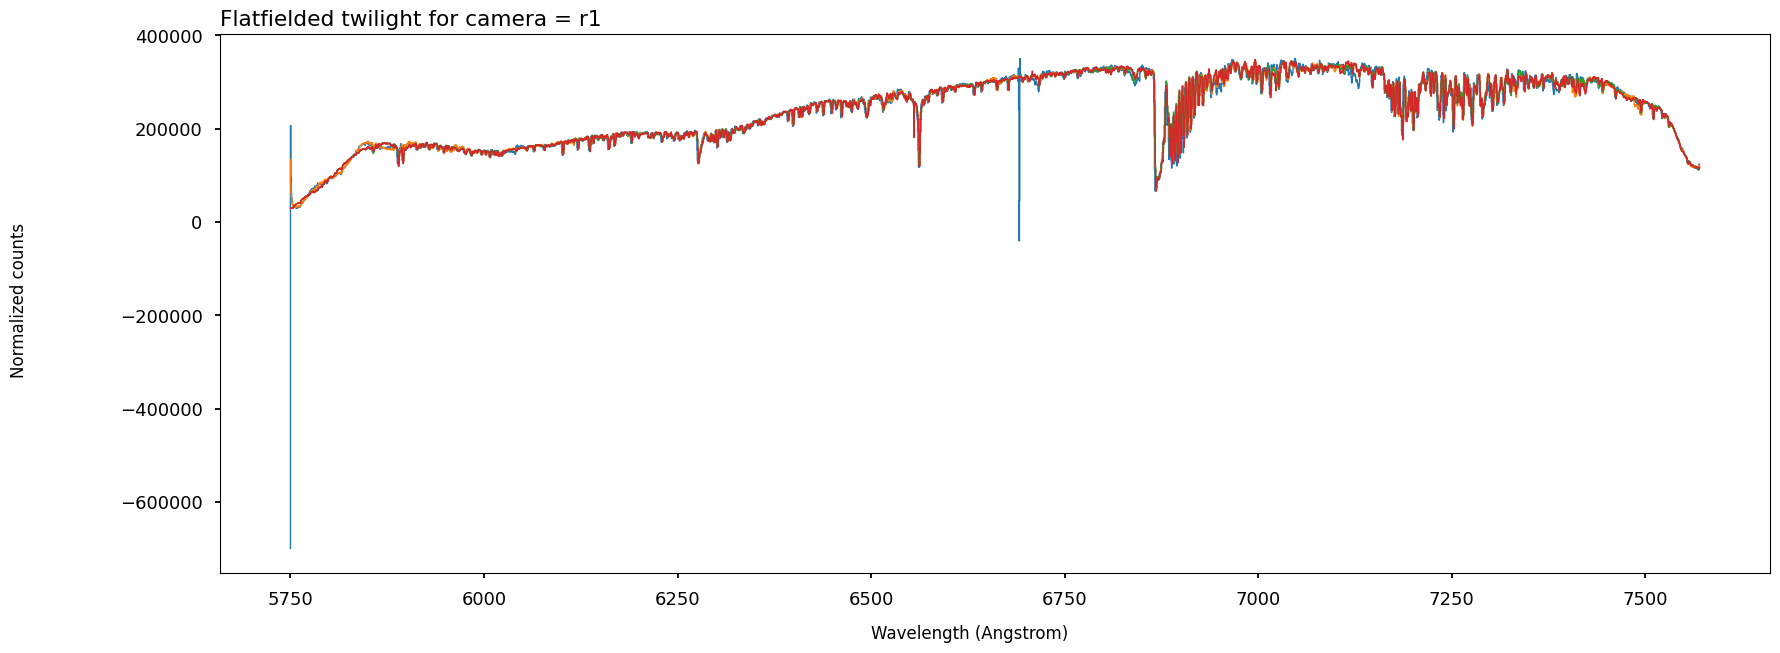

In [39]:
channel = "r"
hflat_paths = sorted(path.expand("lvm_anc", drpver=drpver, tileid="*", mjd="*", kind="h", imagetype="flat", expnum=7832, camera=f"{channel}?"))

hflats = [rssMethod.loadRSS(hflat_path) for hflat_path in hflat_paths]

new_flats = continuum_twilight(rsss=hflats, median_box=5, niter=1000, threshold=0.5, mask_bands=mask_bands[channel], display_plots=True, nknots=50)